In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import gc, sys, os, timeit
%matplotlib inline
fig_size = [0,0]
fig_size[0] = 20
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [2]:
TIME = 365 # 一個購物週期3個月
UNIT_RECENT_COUNT_THREDSHOLD = 10

In [3]:
def time(worker):
    tick = timeit.default_timer()
    ret = worker()
    tock = timeit.default_timer()
    eclipse = tock-tick
    print('In %r:\n Spent %f sec'%(worker, eclipse))
    return eclipse, ret

## Loading...

In [4]:
df_member = pd.read_csv('../Member.csv')
df_ecoupon = pd.read_csv('../ECoupon.csv')
df_promotion = pd.read_csv('../PromotionOrders.csv')
df_main = pd.read_csv('../Orders.csv')


D:\andyl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\andyl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_member['MinOrderDate'].value_counts()

2016-11-11    2462
2016-07-08    2008
2016-11-13    1987
2016-09-28    1852
2016-09-27    1809
2016-04-10    1805
2016-07-09    1624
2016-03-20    1604
2016-03-06    1596
2016-11-12    1579
2016-07-10    1561
2016-07-06    1476
2016-07-07    1445
2015-10-12    1432
2017-11-11    1428
2016-11-14    1371
2016-03-19    1365
2017-11-12    1365
2016-03-13    1363
2016-07-14    1342
2016-03-16    1337
2016-04-09    1333
2016-11-10    1320
2016-03-07    1308
2016-07-15    1250
2016-04-02    1248
2015-12-06    1237
2016-04-21    1237
2016-07-11    1232
2016-03-17    1228
              ... 
2017-01-24      74
2015-05-20      74
2015-06-03      74
2018-02-10      73
2018-02-16      73
2015-05-22      70
2015-06-09      67
2015-05-29      63
2018-02-14      58
2015-05-28      58
2018-02-15      47
2018-02-11      42
2015-06-02      42
2015-05-26      39
2018-02-12      38
2015-05-27      33
2015-05-16      27
2015-05-10      25
2015-05-09      24
2015-05-17      22
2015-05-11      20
2015-05-12  

## 抓出一年的資料

In [6]:
df_main['Date'] = pd.to_datetime(df_main['DateId'].astype(str), format='%Y%m%d')

In [7]:
t_begin = df_main['Date'].min()
t_range = pd.Timedelta(TIME, unit='d')
print(t_begin)

2015-05-06 00:00:00


In [8]:
df_main.drop(labels='DateId', inplace=True, axis=1)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5495276 entries, 0 to 5495275
Data columns (total 28 columns):
MemberId                       int64
OrderGroupCode                 object
TrackSourceTypeDef             object
TrackDeviceTypeDef             object
PayProfileTypeDef              object
SalesOrderSlaveId              int64
SalePageId                     int64
IsMajor                        bool
IsGift                         bool
IsSalePageGift                 bool
Quantity                       int64
UnitPrice                      float64
PromotionDiscount              float64
ECouponId                      int64
ECouponDiscount                float64
SalesOrderSlaveTotalPayment    float64
SalesOrderSlaveDateTime        object
SalesOrderReceiverId           int64
City                           object
District                       object
ZipCode                        float64
StoreName                      object
StoreId                        object
DeliverTypeDef      

In [9]:
df_mains = {}
for i in range(3):
    df_mains[i] = \
        df_main[df_main['Date'] < t_begin + t_range * (i + 1)]\
        [df_main['Date'] >= t_begin + t_range * i]


D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


## Merge Data

In [10]:
for k in df_mains:
    df_mains[k] = df_mains[k].merge(df_ecoupon, on='ECouponId', how='left')
    df_mains[k] = df_mains[k].merge(df_promotion, on='SalesOrderSlaveId', how='left')
    gc.collect()

# 顧客分群 
## 由一季內的單次平均購買 vs 購買次數 進行客群劃分 
   - 分成五群 
       - 流失的客戶 0 vs 0
       

**統計單次消費總額**

In [11]:
main_by_baskets = {}
for k in df_mains:
    main_by_baskets[k] = df_mains[k]\
        .groupby(by=['OrderGroupCode','MemberId'], as_index=False)\
            ['SalesOrderSlaveTotalPayment']\
        .sum()
    print(main_by_baskets[k].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316754 entries, 0 to 316753
Data columns (total 3 columns):
OrderGroupCode                 316754 non-null object
MemberId                       316754 non-null int64
SalesOrderSlaveTotalPayment    316754 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 565158 entries, 0 to 565157
Data columns (total 3 columns):
OrderGroupCode                 565158 non-null object
MemberId                       565158 non-null int64
SalesOrderSlaveTotalPayment    565158 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 17.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 462022 entries, 0 to 462021
Data columns (total 3 columns):
OrderGroupCode                 462022 non-null object
MemberId                       462022 non-null int64
SalesOrderSlaveTotalPayment    462022 non-null float64
dtypes: float64(1), int64(1), object(1)
memory us

### 計算每位會員平均單次消費額
- 用於計算客戶的季度總消費額

In [12]:
def rename_col_to(name, old, new):
    if name == old:
        return new
    else:
        return name
    
member_avgs = {}
for k in df_mains:
    member_avgs[k] = main_by_baskets[k]\
        .groupby(by='MemberId', as_index=False)\
        .agg('mean')
    member_avgs[k].rename(
        columns = lambda r: rename_col_to(r, 'SalesOrderSlaveTotalPayment', 'RecentAveragePurchase'),
        inplace=True)
    print(member_avgs[k].head())

   MemberId  RecentAveragePurchase
0      1329                 306.00
1      1334                 333.00
2      1372                 125.00
3      1373                 181.75
4      1384                 557.00
   MemberId  RecentAveragePurchase
0      1326             249.000000
1      1336           12473.000000
2      1362             591.000000
3      1373             282.666667
4      1384             590.000000
   MemberId  RecentAveragePurchase
0      1384                  721.0
1      1391                 2466.0
2      1448                 1678.0
3      1611                 1915.0
4      1663                 1596.0


**統計客戶的季度總消費額**

In [13]:
member_purchase_cnts = {}
for k in df_mains:
    member_purchase_cnts[k] = main_by_baskets[k]\
        .groupby(by='MemberId', as_index=False)\
        .agg('count')
    print(member_purchase_cnts[k].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187329 entries, 0 to 187328
Data columns (total 3 columns):
MemberId                       187329 non-null int64
OrderGroupCode                 187329 non-null int64
SalesOrderSlaveTotalPayment    187329 non-null int64
dtypes: int64(3)
memory usage: 5.7 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 298739 entries, 0 to 298738
Data columns (total 3 columns):
MemberId                       298739 non-null int64
OrderGroupCode                 298739 non-null int64
SalesOrderSlaveTotalPayment    298739 non-null int64
dtypes: int64(3)
memory usage: 9.1 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 246760 entries, 0 to 246759
Data columns (total 3 columns):
MemberId                       246760 non-null int64
OrderGroupCode                 246760 non-null int64
SalesOrderSlaveTotalPayment    246760 non-null int64
dtypes: int64(3)
memory usage: 7.5 MB
None


In [14]:
member_purchase_medians = {}
member_purchase_averages = {}
for k in df_mains:
    member_avgs[k]['RecentCount'] = member_purchase_cnts[k]['OrderGroupCode']
    member_avgs[k]['RecentTotal'] = member_avgs[k]['RecentCount'] * member_avgs[k]['RecentAveragePurchase']
    member_purchase_medians[k] = member_avgs[k]['RecentAveragePurchase'].median()
    member_purchase_averages[k] = member_avgs[k]['RecentAveragePurchase'].mean()
    print(member_avgs[k].head())
    print(member_purchase_medians[k])

   MemberId  RecentAveragePurchase  RecentCount  RecentTotal
0      1329                 306.00            3        918.0
1      1334                 333.00            3        999.0
2      1372                 125.00            2        250.0
3      1373                 181.75            8       1454.0
4      1384                 557.00            1        557.0
705.0
   MemberId  RecentAveragePurchase  RecentCount  RecentTotal
0      1326             249.000000            1        249.0
1      1336           12473.000000            1      12473.0
2      1362             591.000000            1        591.0
3      1373             282.666667            3        848.0
4      1384             590.000000            1        590.0
835.0
   MemberId  RecentAveragePurchase  RecentCount  RecentTotal
0      1384                  721.0            1        721.0
1      1391                 2466.0            3       7398.0
2      1448                 1678.0            1       1678.0
3      1611 

**印出各購買次數的會員平均單次購買金額的落點**

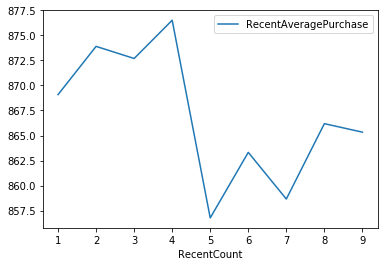

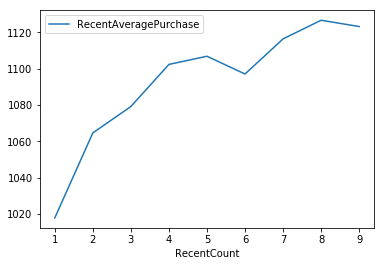

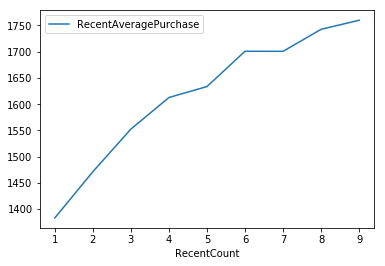

In [15]:
for k in df_mains:
    tmp0 = member_avgs[k]\
        .groupby(by=['RecentCount'], as_index=False)\
            ['RecentAveragePurchase']\
        .mean()
    tmp0[tmp0['RecentCount'] < UNIT_RECENT_COUNT_THREDSHOLD]\
        .plot.line(x='RecentCount', y='RecentAveragePurchase')
    plt.show()
    gc.collect()
    

## 把各顧客分群並標上標記

In [16]:
RecentCount_threshold = 2

In [17]:
df_member_news = {}
for k in df_mains:
    df_member_news[k] = df_member.merge(member_avgs[k], how='left')

In [ ]:
for k in df_mains:
    df_member_news[k][~np.isnan(df_member_news[k]['RecentAveragePurchase'])]

In [ ]:
def set_member_group(row, axis_th_x = RecentCount_threshold, axis_th_y = 0, axis_key_x = 'RecentCount', axis_key_y = 'RecentAveragePurchase'):
    value = 0
    if not np.isnan(row[axis_key_x]) and row[axis_key_x] < axis_th_x:
        if row[axis_key_y] < axis_th_y:
            value = 3
        else:
            value = 2
    elif not np.isnan(row[axis_key_x]):
        if row[axis_key_y] < axis_th_y:
            value = 4
        else:
            value = 1
    
    return value

for k in df_mains:
    df_member_news[k]['MemberGroup'] = \
        df_member_news[k].apply(lambda r: set_member_group(r, RecentCount_threshold, member_purchase_medians[k]), axis = 1)
    #    parallel_apply(df_members[k], set_member_group, RecentCount_threshold, member_purchase_medians[k])
    

In [ ]:
statistics = {}
for k in df_mains:
    statistics[k] = pd.DataFrame()
    statistics[k]['MemberCount'] = df_member_news[k]\
        .groupby(by='MemberGroup')['MemberId']\
        .agg(['count'])['count']
    print(statistics[k])

In [ ]:
for k in df_mains:
    statistics[k]['TotalSales'] = df_member_news[k].groupby(by='MemberGroup')['RecentTotal'].agg(['sum'])['sum']
    print(statistics[k])

In [ ]:
for k in df_mains:
    statistics[k].index = ['潛水客', '高消熟客','低消熟客','低消新客','高消新客']
    print(statistics[k])

## 觀察熱銷商品的客戶分群

** 因為沒有實際物品，所以一個商品代碼當作一種物品 **

In [ ]:
counts = {}
for k in df_mains:
    counts[k] = df_mains[k][df_mains[k]['IsMajor'] == True]['SalePageId'].value_counts()
    counts[k]

In [ ]:
MAX_BEST_SELLING = 20
max_counts_s = {}
for k in df_mains:
    max_counts_s[k] = counts[k].index[0:MAX_BEST_SELLING]
    max_counts_s[k]

In [ ]:
df_in_best_sellings = {}
for k in df_mains:
    df_in_best_sellings[k] = df_mains[k][df_mains[k]['SalePageId'].isin(max_counts_s[k])]

In [ ]:
[df_member_news[k].info() for k in df_mains if True]

In [ ]:
for k in df_mains:
    df_in_best_sellings[k] = df_in_best_sellings[k].merge(
        df_member_news[k].loc[:, ['MemberId', 'MemberGroup']],
        on='MemberId',
    )
    df_in_best_sellings[k].info()

In [ ]:
for k in df_mains:
    df_in_best_sellings[k]['City'].value_counts()

In [ ]:
for k in df_mains: 
    df_in_best_sellings[k]['MemberGroup'].value_counts()

Year: 0
Year: 1
Year: 2


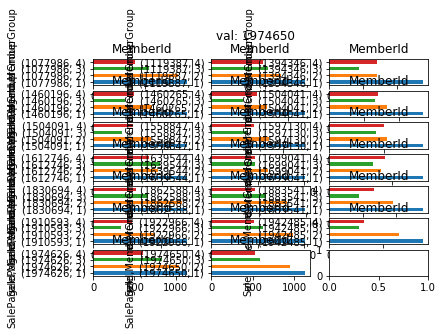

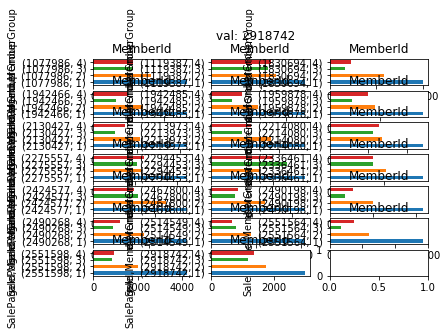

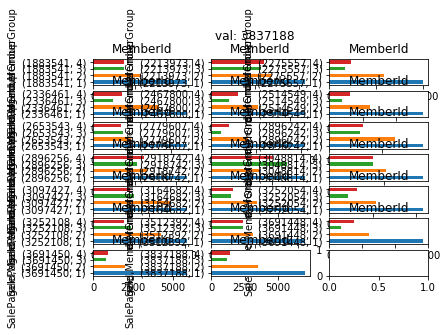

In [48]:
_member_groups_by_hottest_items_s = {}
_gs = {}
for k in df_mains: 
    _member_groups_by_hottest_items_s[k] =\
    df_in_best_sellings[k].groupby(by=['SalePageId', 'MemberGroup']).count()['MemberId']
    _member_groups_by_hottest_items_s[k].columns = ['MemberGroup', 'Counts']
    _gs[k] = _member_groups_by_hottest_items_s[k].groupby('SalePageId')
    fig, axes = plt.subplots(nrows=7, ncols=3)
    print('Year: {}'.format(k))
    for it in _gs:
        i = 0
        for val, group in _gs[it]:
            group.plot.barh(subplots=True, ax=axes[i//3, i%3], title = 'val: {}'.format(val))
            i += 1

## 買熱門商品的顧客分群

In [3]:
_member_groups_by_hottest_items_s

NameError: name '_member_groups_by_hottest_items_s' is not defined

In [ ]:

for k in df_mains:
    _member_groups_by_hottest_items_s[k] =\
    df_in_best_sellings[k].groupby(by=['SalePageId', 'MemberGroup']).count()['MemberId']
    _member_groups_by_hottest_items_s[k].columns = ['MemberGroup', 'Counts']
    _gs[k] = _member_groups_by_hottest_items_s[k].groupby('SalePageId')
    fig, axes = plt.subplots(nrows=7, ncols=3)
    print('Year: {}'.format(k))
    for it in _gs:
        i = 0
        for val, group in _gs[it]:
            group.plot.barh(subplots=True, ax=axes[i//3, i%3], title = 'val: {}'.format(val))
            i += 1
    